In [1]:
import sys
sys.path.append('/home/dylan-kmutt/ubpd')

In [2]:
from src.helper import get_train_test_pids

train_v_pids, test_pids = get_train_test_pids("../../data/dataset/images/", seed=42)
all_pids = train_v_pids + test_pids
len(all_pids)

88

In [3]:
from typing import List, Tuple
import random
import math

def split_train_and_test(pids: List[int], seed: int = 42) -> Tuple[List[int], List[int]]:
    if not pids:
        return [], []

    # De-duplicate while preserving order
    unique = list(dict.fromkeys(pids))
    n = len(unique)

    # Reproducible shuffle
    rng = random.Random(seed)
    idxs = list(range(n))
    rng.shuffle(idxs)
    shuffled = [unique[i] for i in idxs]

    # Compute test size (≈15%); keep at least 1 test if possible, and at least 1 train
    raw_test = int(round(n * 0.15))
    if n >= 2:
        test_size = max(1, min(raw_test, n - 1))
    else:
        test_size = 0  # only one item → all train

    test_ids = shuffled[:test_size]
    train_ids = shuffled[test_size:]

    return train_ids, test_ids


In [4]:
ultrasound_1_pids = [i for i in range(7, 44) if i in all_pids]

sub_1_ultrasound_2_pids = [i for i in range(47, 166) if i in all_pids]
sub_2_ultrasound_2_pids = [i for i in range(1, 6) if i in all_pids]
ultrasound_2_pids = sub_1_ultrasound_2_pids + sub_2_ultrasound_2_pids

print(f"Ultrasound 1 PIDS: {len(ultrasound_1_pids)}")
print(f"Ultrasound 2 PIDS: {len(ultrasound_2_pids)}")

Ultrasound 1 PIDS: 35
Ultrasound 2 PIDS: 50


In [5]:
u1_train_pids, u1_test_pids = split_train_and_test(ultrasound_1_pids)
u2_train_pids, u2_test_pids = split_train_and_test(ultrasound_2_pids)

print(f"Ultrasound 1: train {len(u1_train_pids)} pids, test {len(u1_test_pids)} pids [{', '.join(map(str, u1_test_pids))}]")
print(f"Ultrasound 2: train {len(u2_train_pids)} pids, test {len(u2_test_pids)} pids [{', '.join(map(str, u2_test_pids))}]")

Ultrasound 1: train 30 pids, test 5 pids [16, 19, 12, 28, 40]
Ultrasound 2: train 42 pids, test 8 pids [79, 77, 71, 63, 51, 1, 81, 61]


In [6]:
from src.helper import get_cv_pids

u1_cv_pids = get_cv_pids(u1_train_pids, cv=5)
u2_cv_pids = get_cv_pids(u2_train_pids, cv=5)


# **Ultrasound 2**

In [7]:
from src.dataset import UBPDataset
from src.preprocessing import PairedTransform

In [11]:
import numpy as np

from src.train import Trainer
from src.evaluate import Evaluator
from src.helper import (
    set_seed,
    _build_model_factory,
    str2bool,
    _make_paired_transform,
    get_train_test_pids,
    get_cv_pids,
    aggregate_fold_metrics,
)

def experiment(variants, seed=42, exp_id=000000):
    # CV
    all_histories = []
    fold_overall_means = []
    fold_results = []  # store per-fold evaluator outputs (dicts)

    # exp_id = random.randint(int(1e5), int(1e6) - 1)
    model_name = variants["model"]

    set_seed(seed)
    print(f"\n🚀 Beginning experiment #{exp_id}")
    print("=" * 60)

    include_classes = variants.get("include_classes")
    class_names = {
        1: "dongmai (artery)",
        2: "jingmai (vein)",
        3: "jirouzuzhi (muscle)",
        4: "shenjing (nerve)",
    }
    print("Included classes:")
    for cid in include_classes:
        print(f"  {cid}: {class_names.get(cid, 'unknown')}")
    print(f"\n- Model: {model_name}")
    print(f"- Augment: {variants['augment']}")

    include_classes = variants["include_classes"]
    n_inc = len(include_classes)
    if n_inc == 1:
        variants["loss"] = "bce"
        num_classes_for_model = 1  # single foreground channel
        keep_original_indices = True  # irrelevant when binary
    else:
        variants["loss"] = "ce"
        num_classes_for_model = n_inc + 1  # background + selected classes only
        keep_original_indices = False  # remap selected IDs to contiguous {0..K}
    variants["num_classes"] = num_classes_for_model

    print(
        f"- Using loss='{variants['loss']}' with model num_classes={num_classes_for_model}"
    )
    if not keep_original_indices:
        print(
            "- Remapping labels to contiguous IDs: background=0, selected classes=1..K"
        )
    print(f"- Image size: {variants['image_size']}")
    print("-" * 60)


    paired_train_tf = PairedTransform(size=variants["image_size"], aug=variants["augment"])
    paired_test_tf = PairedTransform(size=variants["image_size"], aug=False)
    test_dataset = UBPDataset(
        p_ids=u2_test_pids,
        include_classes=include_classes,
        image_dir="../../data/dataset/images",
        json_dir="../../data/dataset/labels/json_train",
        joint_transform=paired_test_tf,
        keep_original_indices=True,
    )

    print("Test landmarks stat: ")
    test_dataset.print_stats()
    len(test_dataset)

    for fold in range(1, len(u2_cv_pids)+1):
        train_pids, val_pids = u2_cv_pids[fold-1]

        print(f"\n📂 Fold {fold}/{len(u2_cv_pids)}")
        print(f"  Train patient IDs: {train_pids}")
        print(f"  Val   patient IDs: {val_pids}\n")

        train_dataset = UBPDataset(
            p_ids=train_pids,
            include_classes=include_classes,
            image_dir="../../data/dataset/images",
            json_dir="../../data/dataset/labels/json_train",
            joint_transform=paired_train_tf,
            keep_original_indices=keep_original_indices,  # <--- important
        )

        val_dataset = UBPDataset(
            p_ids=val_pids,
            include_classes=include_classes,
            image_dir="../../data/dataset/images",
            json_dir="../../data/dataset/labels/json_train",
            joint_transform=paired_test_tf,
            keep_original_indices=keep_original_indices,  # <--- important
        )

        print("Train landmarks stat: ")
        train_dataset.print_stats()
        print()
        print("Validation landmarks stat:")
        val_dataset.print_stats()
        val_dataset.visualize_image_transform(0)

        make_model = _build_model_factory(model_name)
        model = make_model(num_classes=num_classes_for_model)

        trainer = Trainer(
            exp_id=exp_id,
            fold_num=fold,
            model=model,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            arguments=variants,
        )
        history = trainer.train()
        all_histories.append(history)

        if history["val_loss"]:
            best_idx = int(np.argmin(history["val_loss"]))
            print(
                f"  ✅ Best @ epoch {best_idx+1}: val_loss={history['val_loss'][best_idx]:.4f} | val_dice={history['val_dice'][best_idx]:.4f}"
            )
        print("-" * 60)

        # Evaluate one fold (you can move this after the loop to evaluate the final/best model instead)
        evaluator = Evaluator(
            trainer.model,
            test_dataset,
            num_classes=num_classes_for_model,
            ignore_empty_classes=False,
        )
        res = evaluator.evaluate_dice_score(show_plot=True)
        evaluator.visualize_ranked()
                # collect overall mean dice for this fold if available
        try:
            overall_mean = res.get("overall", {}).get("mean", float("nan"))
        except Exception:
            overall_mean = float("nan")
        fold_overall_means.append(
            float(overall_mean) if overall_mean is not None else float("nan")
        )
        fold_results.append(res)

    overall_mean, overall_std, per_class_stats = aggregate_fold_metrics(fold_results)
    if not np.isnan(overall_mean):
        print(
            f"\n🎯 Average overall Dice across folds: {overall_mean:.4f} ± {overall_std:.4f}  (n={len(fold_results)})"
        )
    else:
        print("\n⚠️ No per-fold overall Dice scores collected.")

    # Print per-landmark (per-class) averages
    if per_class_stats:
        print("\n📌 Per-landmark average Dice across folds:")
        for cid in sorted(per_class_stats.keys()):
            stats = per_class_stats[cid]
            name = class_names.get(cid, f"class_{cid}")
            print(
                f"  {cid}: {name:<20s} mean±std: {stats['mean']:.4f} ± {stats['std']:.4f}  (folds={stats['n_folds']})"
            )
    else:
        print("\n⚠️ No per-class stats available to aggregate.")

    print("\n✅ Experiment complete across folds.")
    return {
        "histories": all_histories,
        "test_dataset": test_dataset,
        "fold_overall_means": fold_overall_means,
    }



🚀 Beginning experiment #0
Included classes:
  4: shenjing (nerve)

- Model: unet
- Augment: True
- Using loss='bce' with model num_classes=1
- Image size: 512
------------------------------------------------------------
Test landmarks stat: 
Nerve  present: 102/103 images

📂 Fold 1/5
  Train patient IDs: [64, 89, 2, 47, 49, 99, 100, 87, 60, 66, 52, 70, 92, 76, 3, 69, 82, 73, 98, 97, 53, 93, 84, 86, 5, 50, 96, 62, 88, 4, 85, 68, 94, 58]
  Val   patient IDs: [78, 75, 90, 65, 67, 83, 48, 131]

Train landmarks stat: 
Nerve  present: 354/380 images

Validation landmarks stat:
Nerve  present: 82/82 images


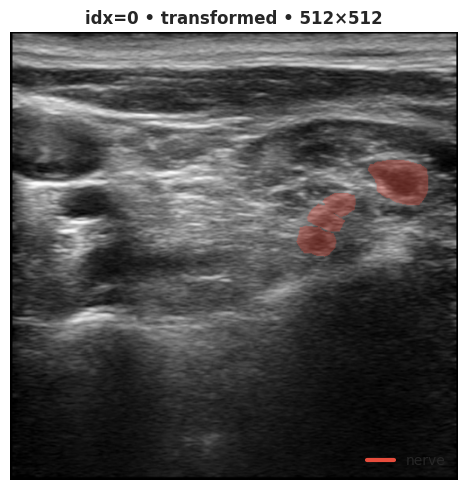

Epoch 001/100 | lr=1.000e-03 train_loss=0.3685 val_loss=1.8503 train_dice=0.0244 val_dice=0.0474 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.2076 val_loss=0.2225 train_dice=0.0485 val_dice=0.0002 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.1651 val_loss=0.1726 train_dice=0.0565 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.1315 val_loss=0.1382 train_dice=0.0587 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.1137 val_loss=0.1215 train_dice=0.0629 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.1010 val_loss=0.1078 train_dice=0.0651 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.0898 val_loss=0.1012 train_dice=0.0644 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.0808 val_loss=0.0939 train_dice=0.0605 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=

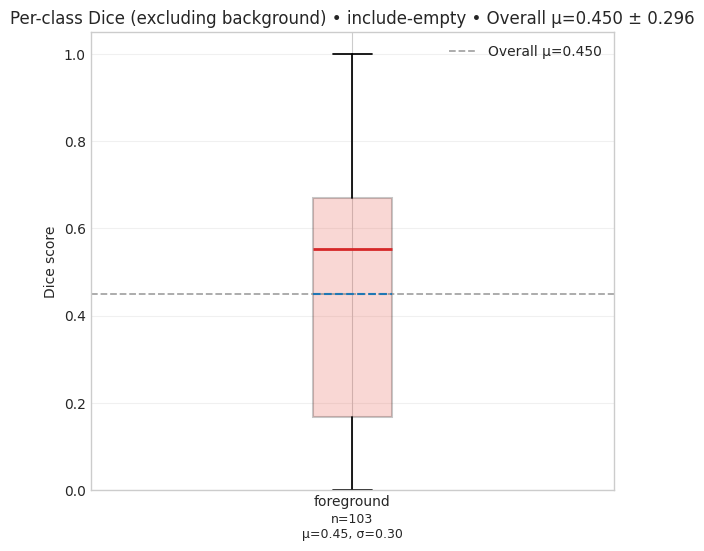

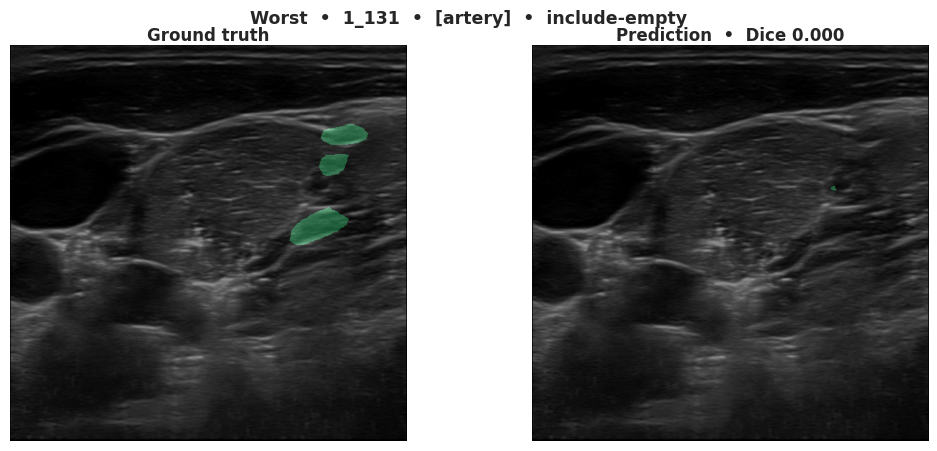

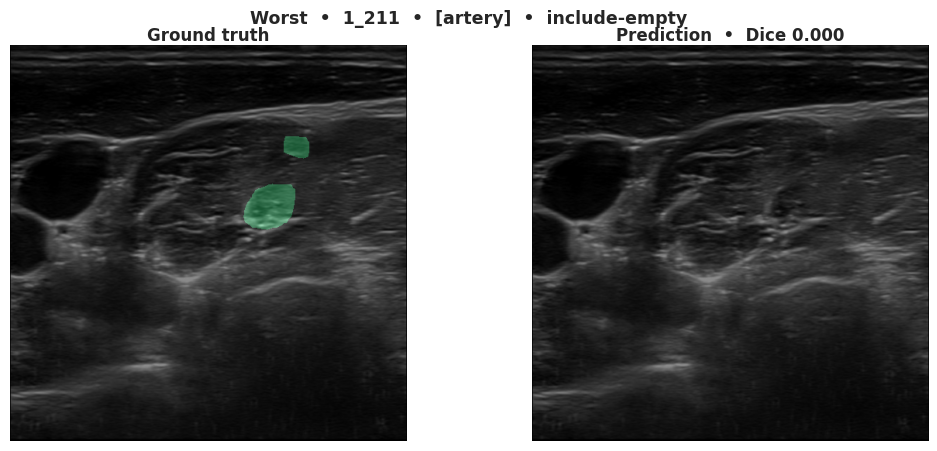

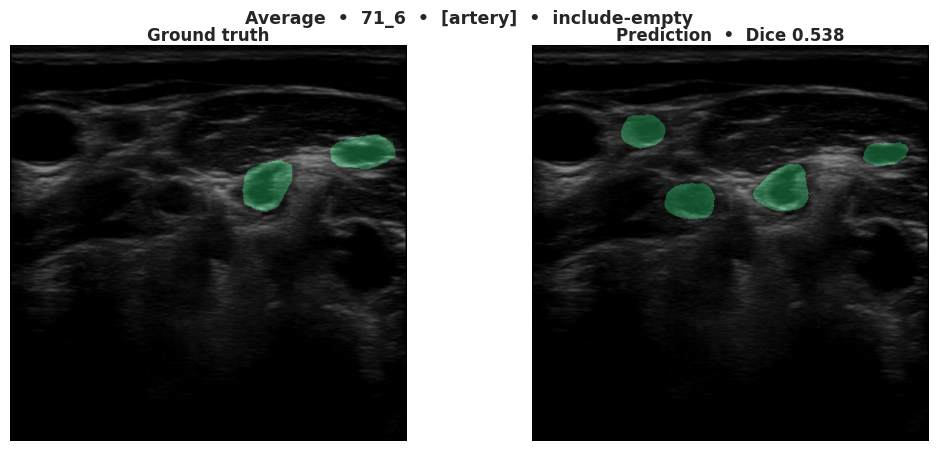

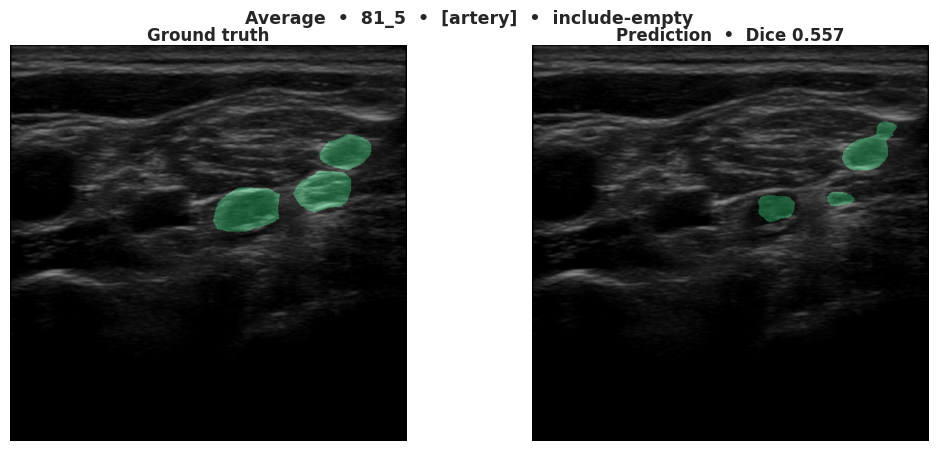

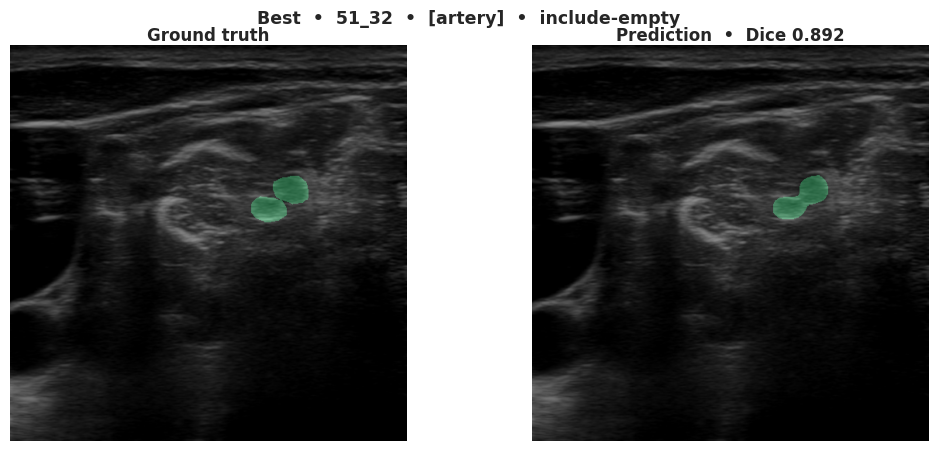

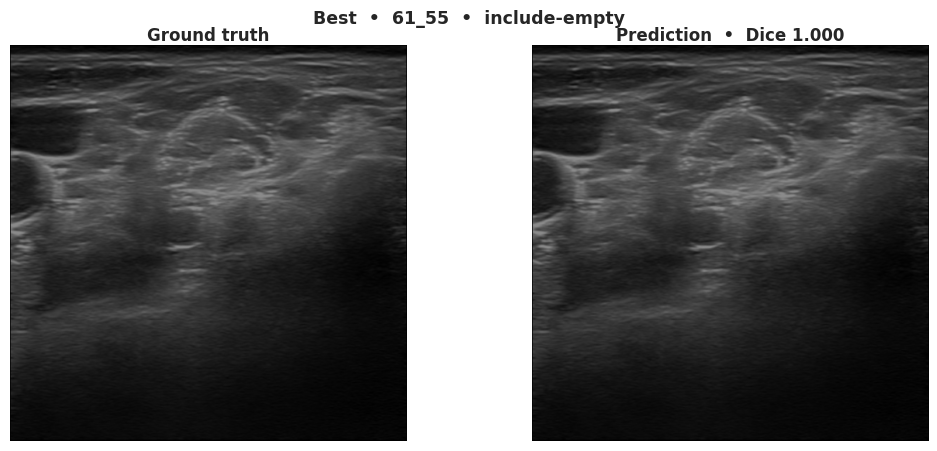


📂 Fold 2/5
  Train patient IDs: [78, 75, 90, 65, 67, 83, 48, 131, 60, 66, 52, 70, 92, 76, 3, 69, 82, 73, 98, 97, 53, 93, 84, 86, 5, 50, 96, 62, 88, 4, 85, 68, 94, 58]
  Val   patient IDs: [64, 89, 2, 47, 49, 99, 100, 87]

Train landmarks stat: 
Nerve  present: 359/373 images

Validation landmarks stat:
Nerve  present: 77/89 images


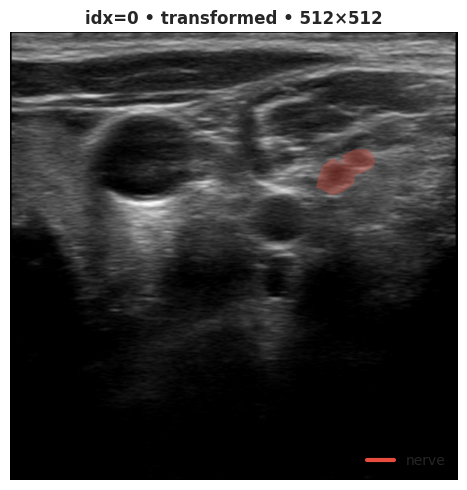

Epoch 001/100 | lr=1.000e-03 train_loss=0.4227 val_loss=3.1927 train_dice=0.0181 val_dice=0.0391 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.2053 val_loss=0.1823 train_dice=0.0209 val_dice=0.1331 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.1657 val_loss=0.1459 train_dice=0.0234 val_dice=0.1331 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.1390 val_loss=0.1250 train_dice=0.0339 val_dice=0.1331 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.1230 val_loss=0.1052 train_dice=0.0339 val_dice=0.1331 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.1100 val_loss=0.0918 train_dice=0.0234 val_dice=0.1331 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.0999 val_loss=0.0804 train_dice=0.0326 val_dice=0.1331 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.0888 val_loss=0.0707 train_dice=0.0545 val_dice=0.1331 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=

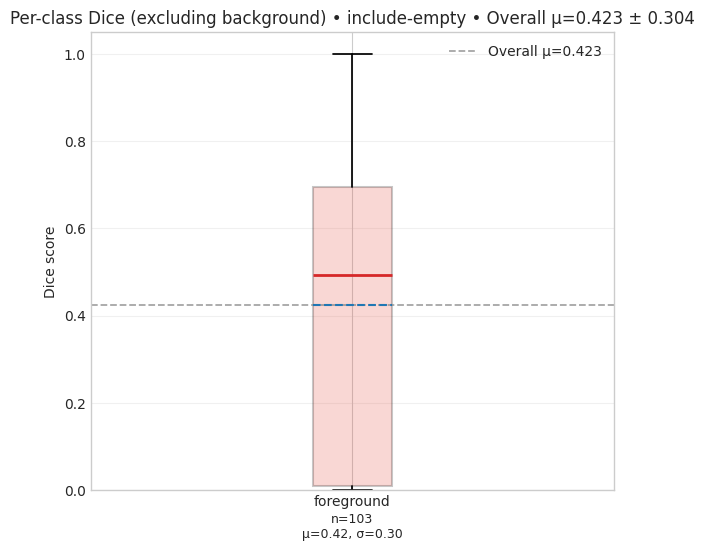

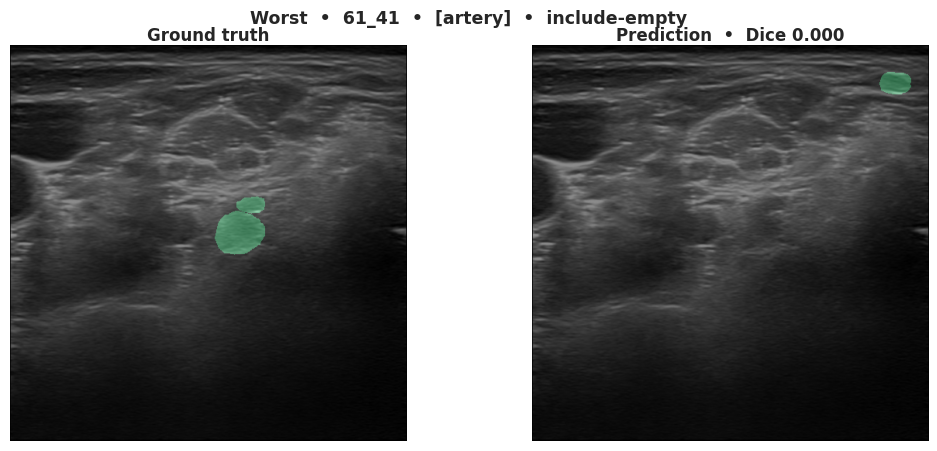

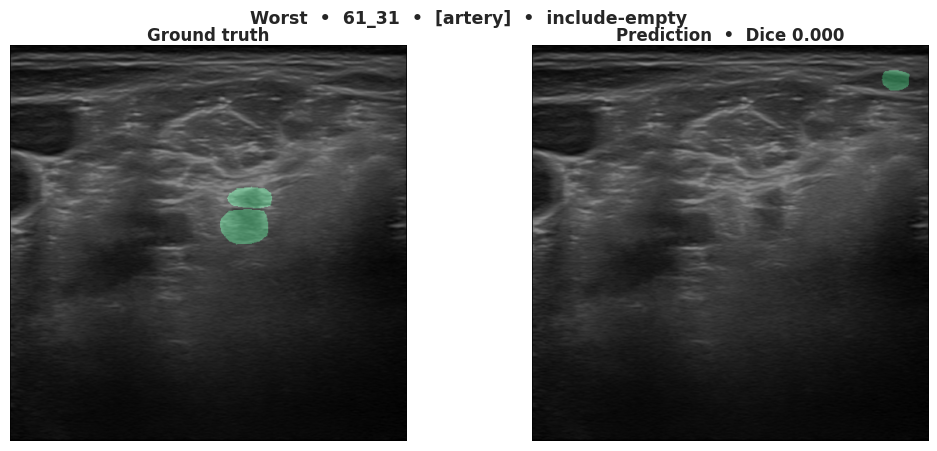

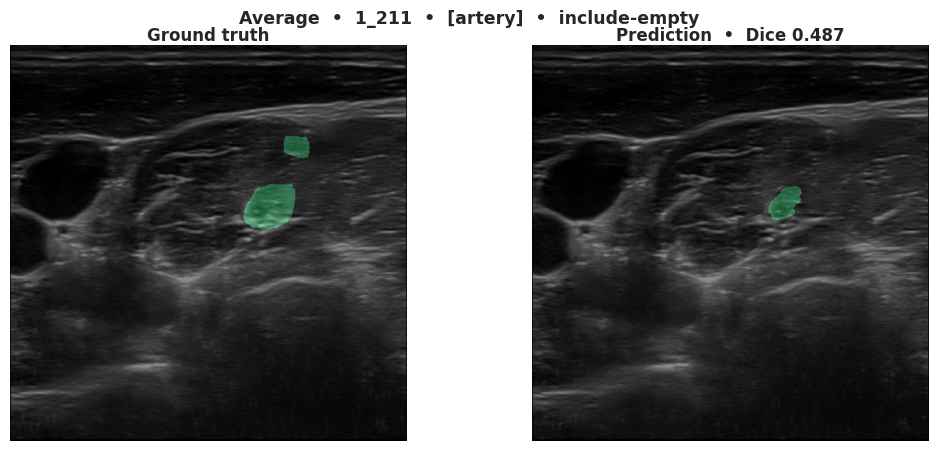

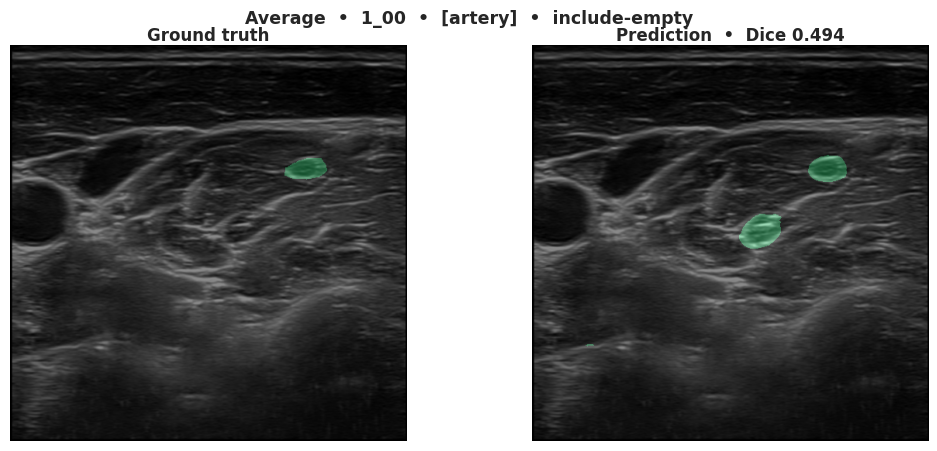

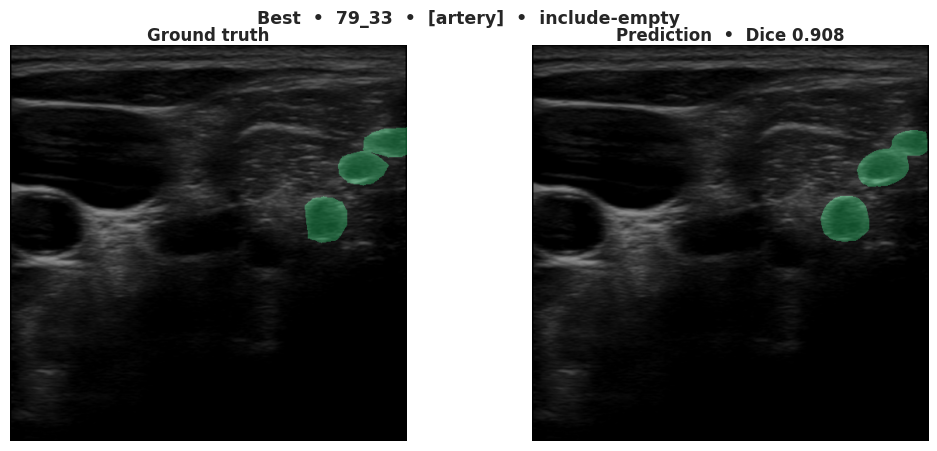

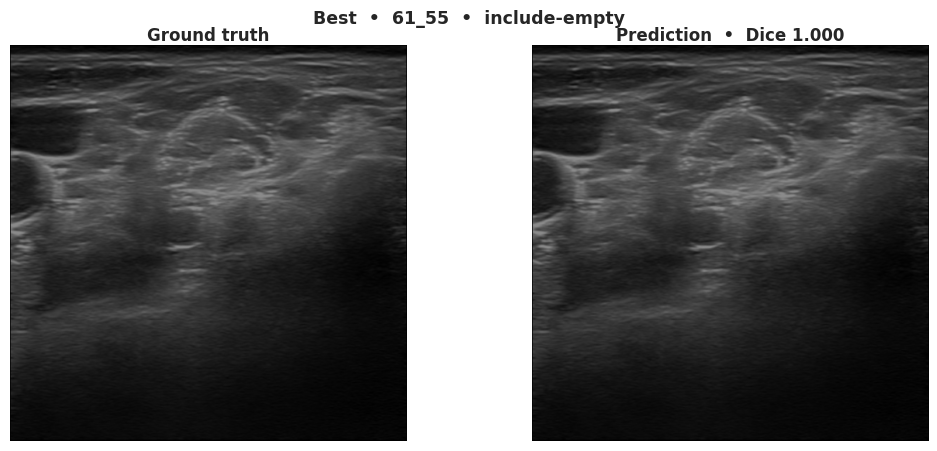


📂 Fold 3/5
  Train patient IDs: [78, 75, 90, 65, 67, 83, 48, 131, 64, 89, 2, 47, 49, 99, 100, 87, 82, 73, 98, 97, 53, 93, 84, 86, 5, 50, 96, 62, 88, 4, 85, 68, 94, 58]
  Val   patient IDs: [60, 66, 52, 70, 92, 76, 3, 69]

Train landmarks stat: 
Nerve  present: 337/361 images

Validation landmarks stat:
Nerve  present:  99/101 images


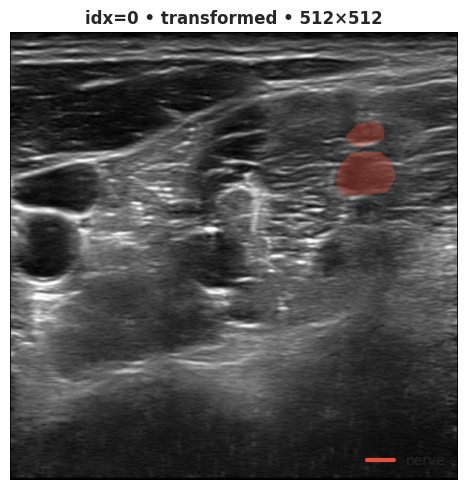

Epoch 001/100 | lr=1.000e-03 train_loss=0.5258 val_loss=1.0706 train_dice=0.0154 val_dice=0.0062 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.3053 val_loss=0.3159 train_dice=0.0230 val_dice=0.0144 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.2421 val_loss=0.2773 train_dice=0.0422 val_dice=0.0121 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.1955 val_loss=0.1785 train_dice=0.0482 val_dice=0.0089 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.1646 val_loss=0.1523 train_dice=0.0535 val_dice=0.0179 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.1444 val_loss=0.1376 train_dice=0.0544 val_dice=0.0179 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.1273 val_loss=0.1243 train_dice=0.0605 val_dice=0.0179 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.1119 val_loss=0.1057 train_dice=0.0621 val_dice=0.0179 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=

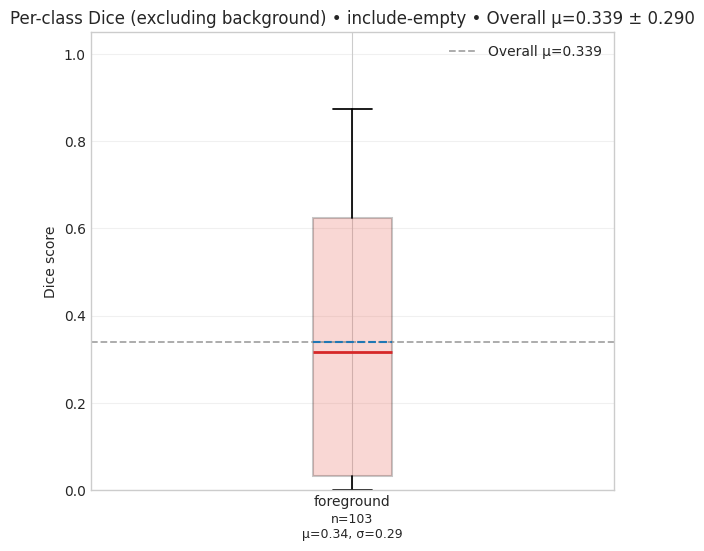

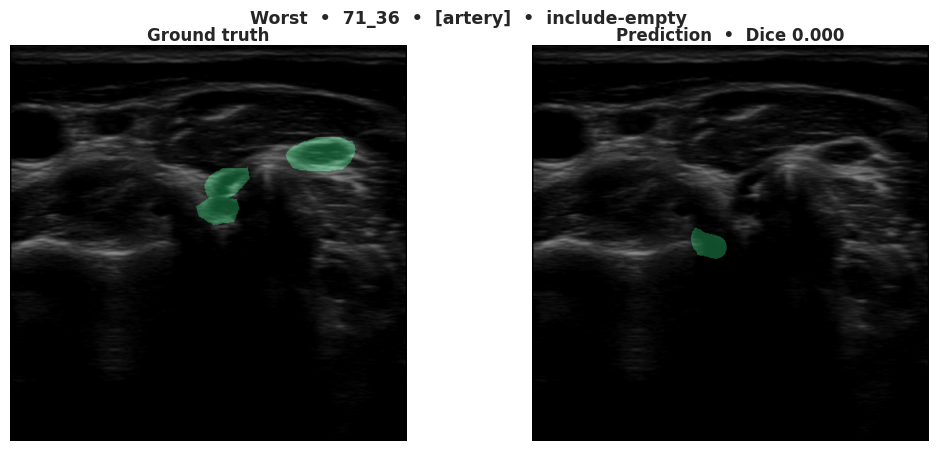

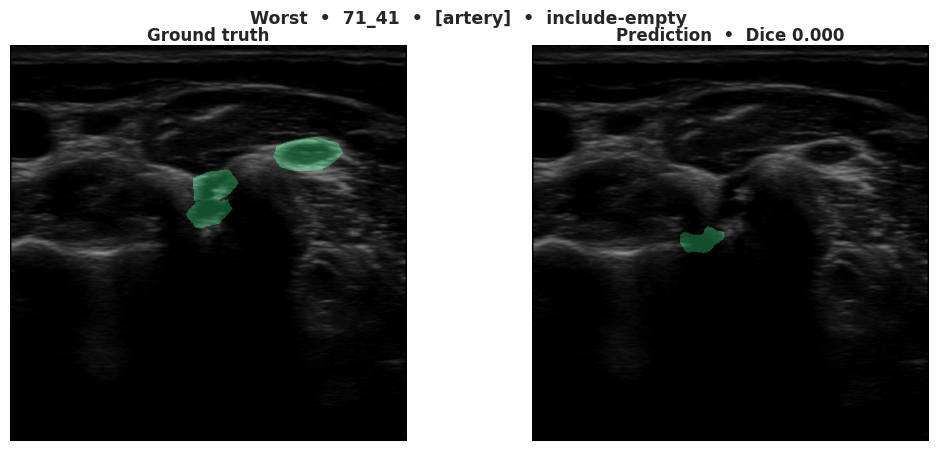

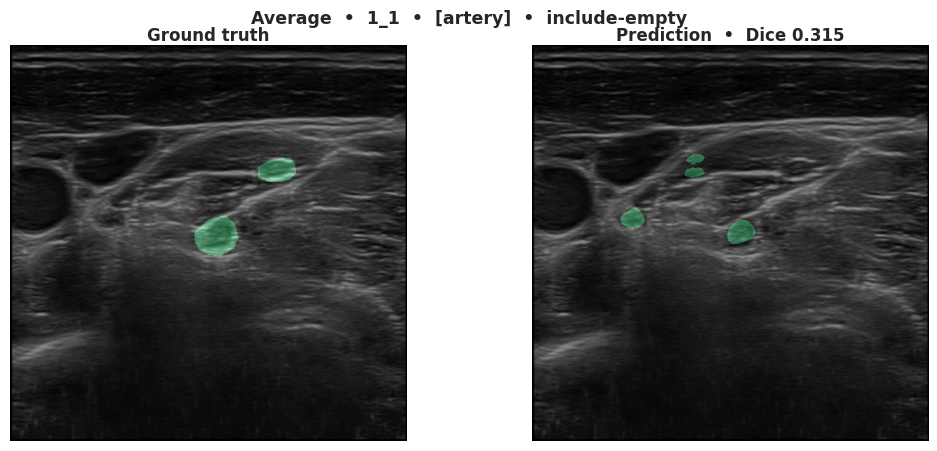

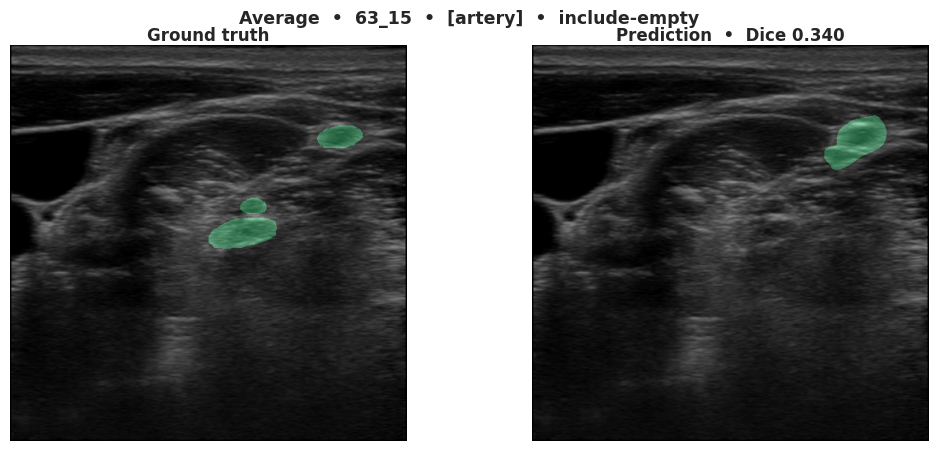

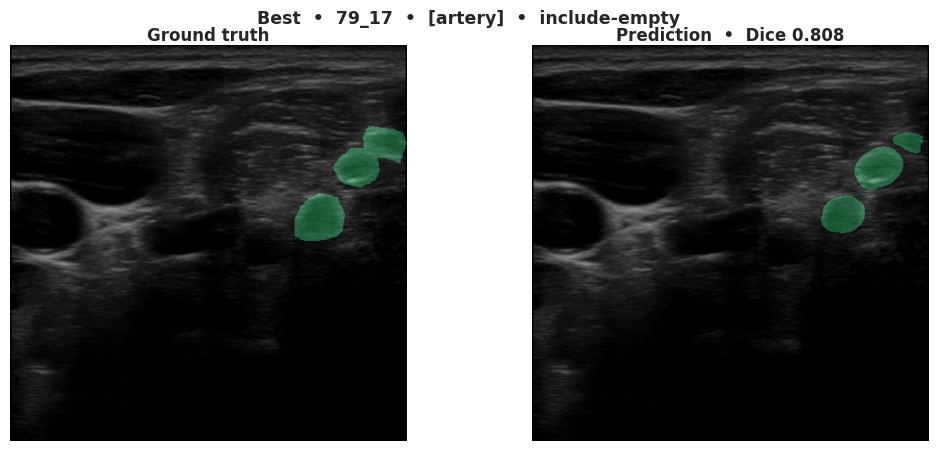

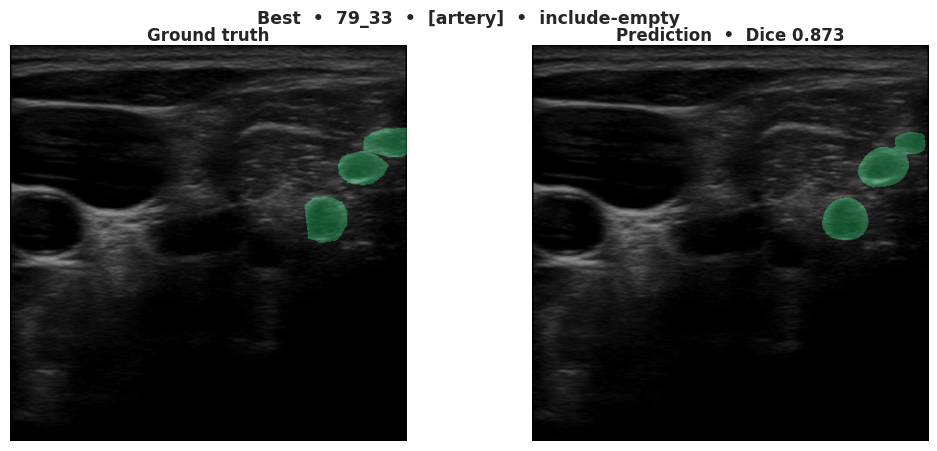


📂 Fold 4/5
  Train patient IDs: [78, 75, 90, 65, 67, 83, 48, 131, 64, 89, 2, 47, 49, 99, 100, 87, 60, 66, 52, 70, 92, 76, 3, 69, 5, 50, 96, 62, 88, 4, 85, 68, 94, 58]
  Val   patient IDs: [82, 73, 98, 97, 53, 93, 84, 86]

Train landmarks stat: 
Nerve  present: 355/379 images

Validation landmarks stat:
Nerve  present: 81/83 images


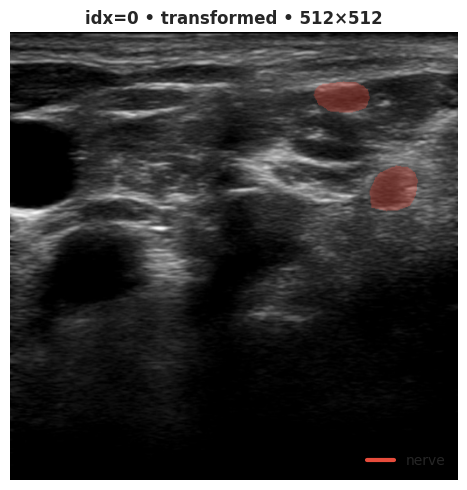

Epoch 001/100 | lr=1.000e-03 train_loss=0.4571 val_loss=0.6409 train_dice=0.0151 val_dice=0.0443 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.2213 val_loss=3.9425 train_dice=0.0288 val_dice=0.0262  (patience 1/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.1771 val_loss=0.1752 train_dice=0.0130 val_dice=0.0208 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.1444 val_loss=0.1465 train_dice=0.0234 val_dice=0.0208 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.1246 val_loss=0.1275 train_dice=0.0339 val_dice=0.0208 [BEST] (patience 0/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.1098 val_loss=0.1152 train_dice=0.0443 val_dice=0.0208 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.0974 val_loss=0.1030 train_dice=0.0521 val_dice=0.0208 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.0885 val_loss=0.0940 train_dice=0.0417 val_dice=0.0208 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.0797

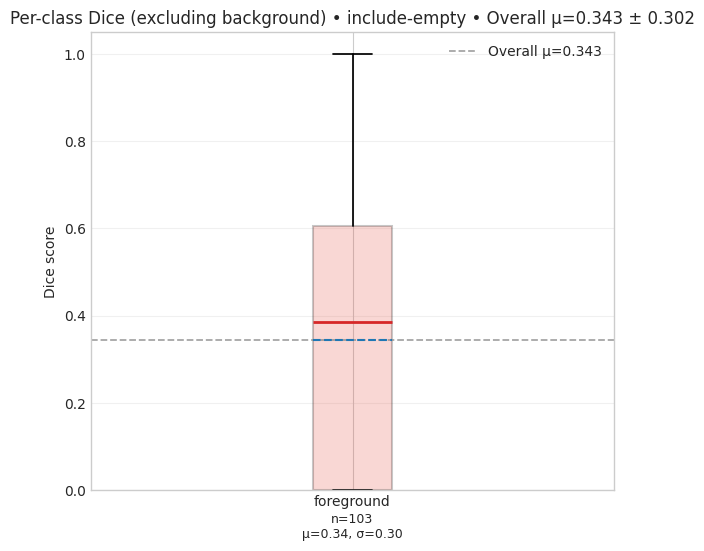

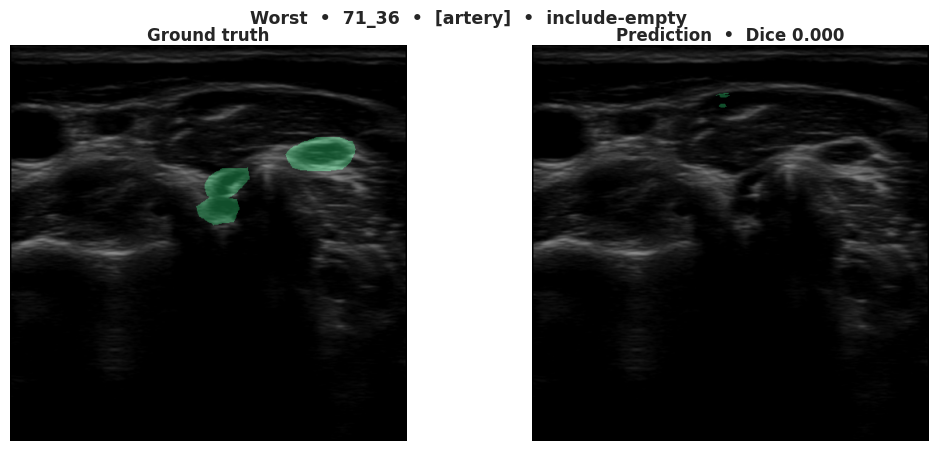

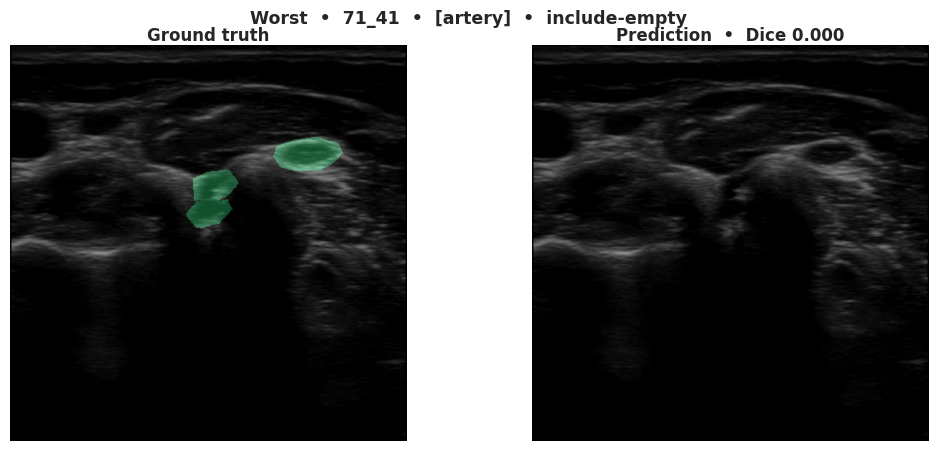

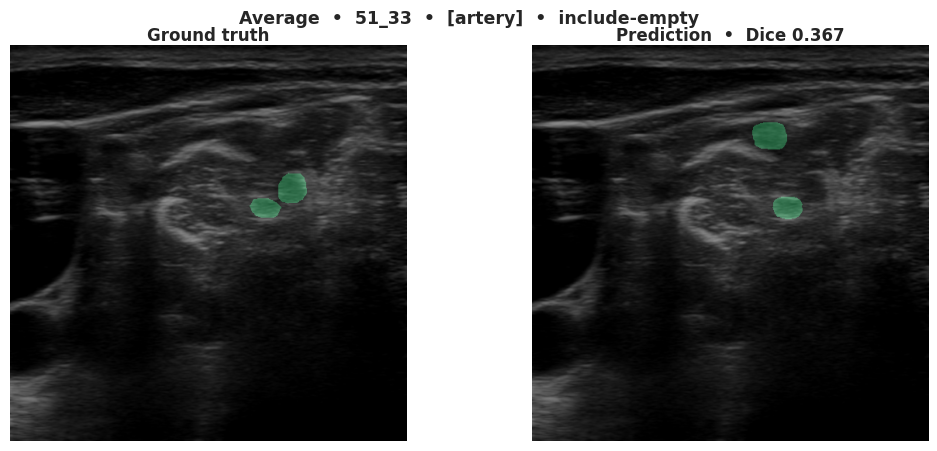

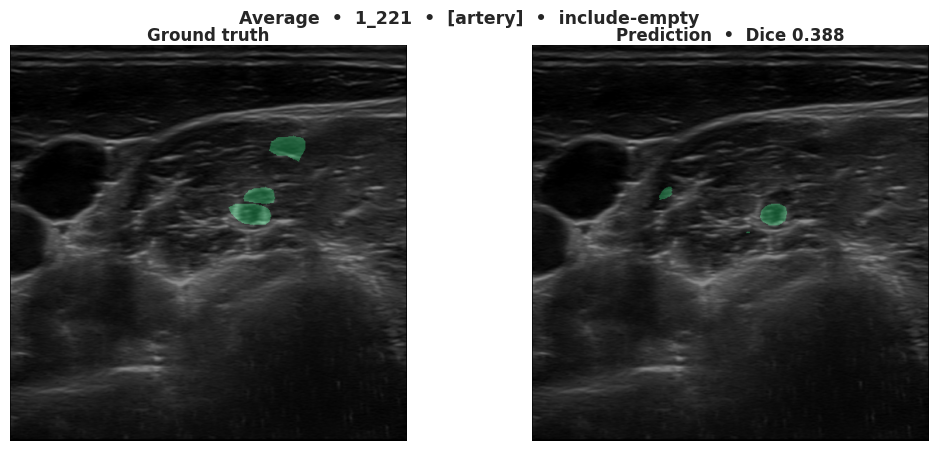

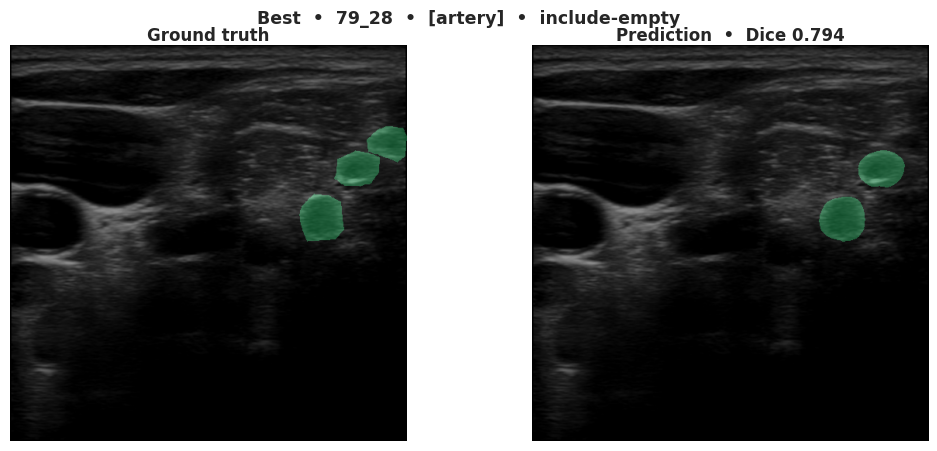

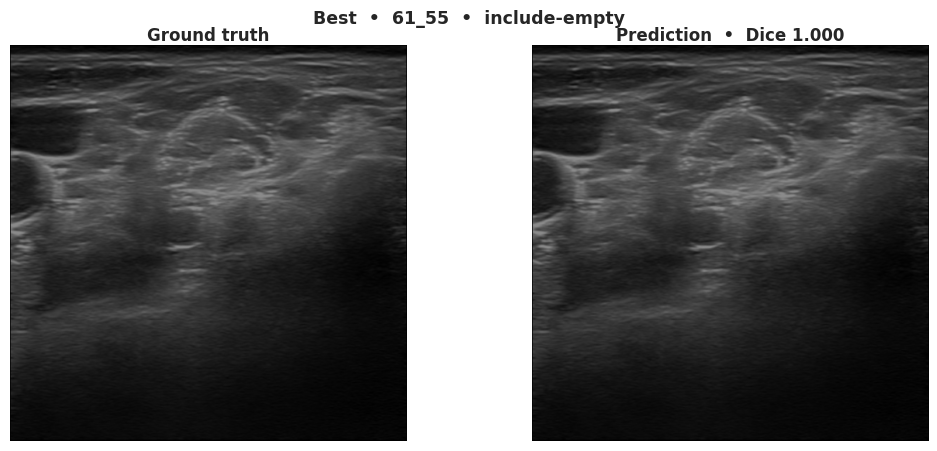


📂 Fold 5/5
  Train patient IDs: [78, 75, 90, 65, 67, 83, 48, 131, 64, 89, 2, 47, 49, 99, 100, 87, 60, 66, 52, 70, 92, 76, 3, 69, 82, 73, 98, 97, 53, 93, 84, 86]
  Val   patient IDs: [5, 50, 96, 62, 88, 4, 85, 68, 94, 58]

Train landmarks stat: 
Nerve  present: 339/355 images

Validation landmarks stat:
Nerve  present:  97/107 images


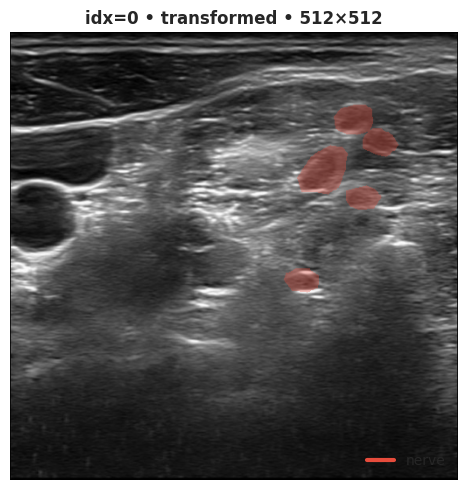

Epoch 001/100 | lr=1.000e-03 train_loss=0.5090 val_loss=0.3149 train_dice=0.0196 val_dice=0.0000 [BEST] (patience 0/20)
Epoch 002/100 | lr=1.000e-03 train_loss=0.3097 val_loss=0.2557 train_dice=0.0102 val_dice=0.0893 [BEST] (patience 0/20)
Epoch 003/100 | lr=1.000e-03 train_loss=0.2383 val_loss=0.2212 train_dice=0.0166 val_dice=0.0893 [BEST] (patience 0/20)
Epoch 004/100 | lr=1.000e-03 train_loss=0.1948 val_loss=0.1848 train_dice=0.0327 val_dice=0.0893 [BEST] (patience 0/20)
Epoch 005/100 | lr=1.000e-03 train_loss=0.1700 val_loss=0.1863 train_dice=0.0247 val_dice=0.0049  (patience 1/20)
Epoch 006/100 | lr=1.000e-03 train_loss=0.1473 val_loss=0.1315 train_dice=0.0300 val_dice=0.0893 [BEST] (patience 0/20)
Epoch 007/100 | lr=1.000e-03 train_loss=0.1271 val_loss=0.1167 train_dice=0.0299 val_dice=0.0893 [BEST] (patience 0/20)
Epoch 008/100 | lr=1.000e-03 train_loss=0.1117 val_loss=0.1065 train_dice=0.0380 val_dice=0.0893 [BEST] (patience 0/20)
Epoch 009/100 | lr=1.000e-03 train_loss=0.0990

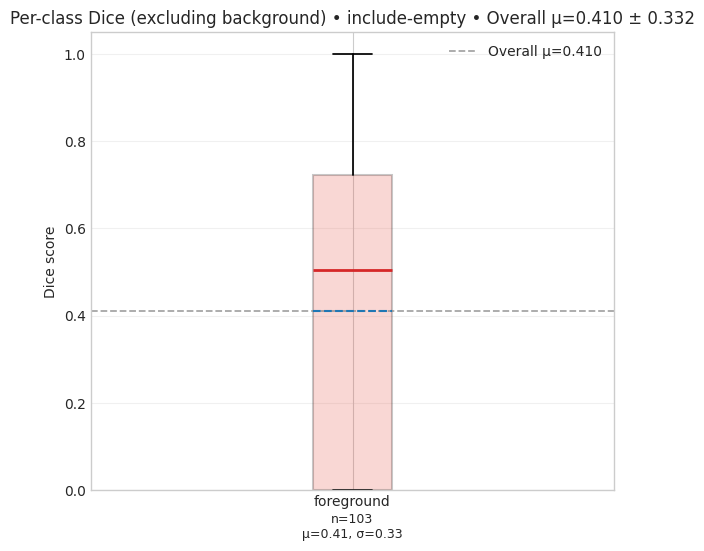

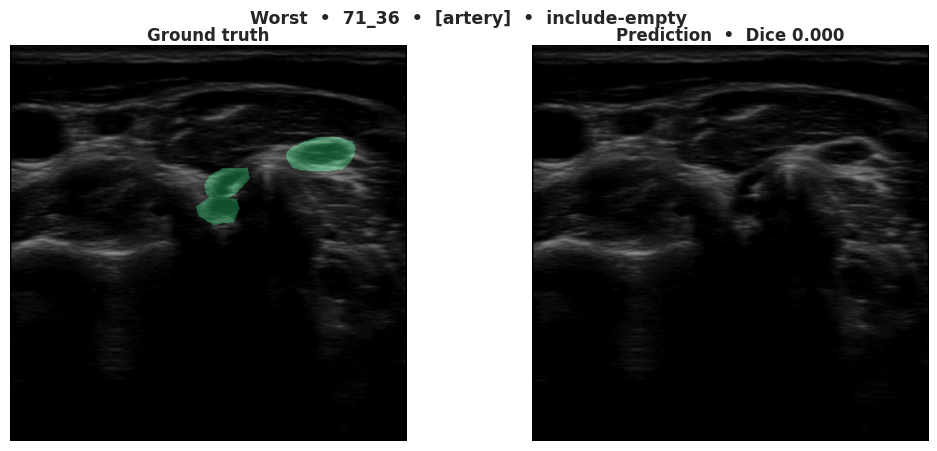

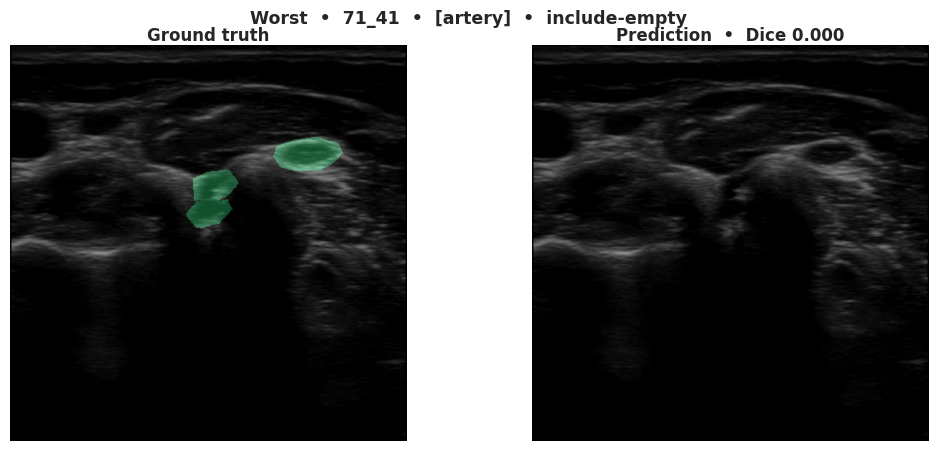

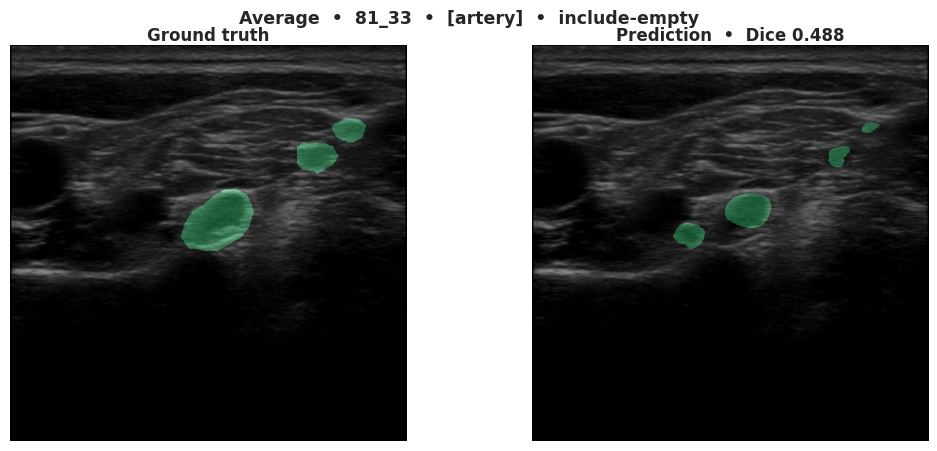

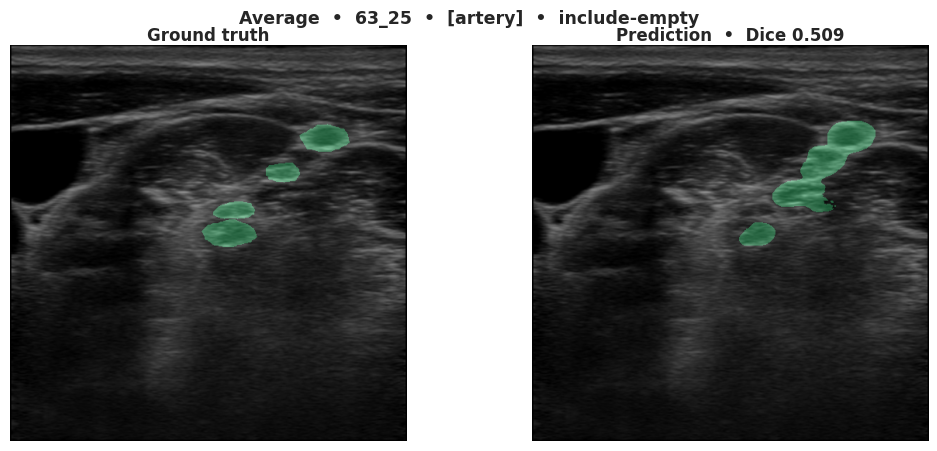

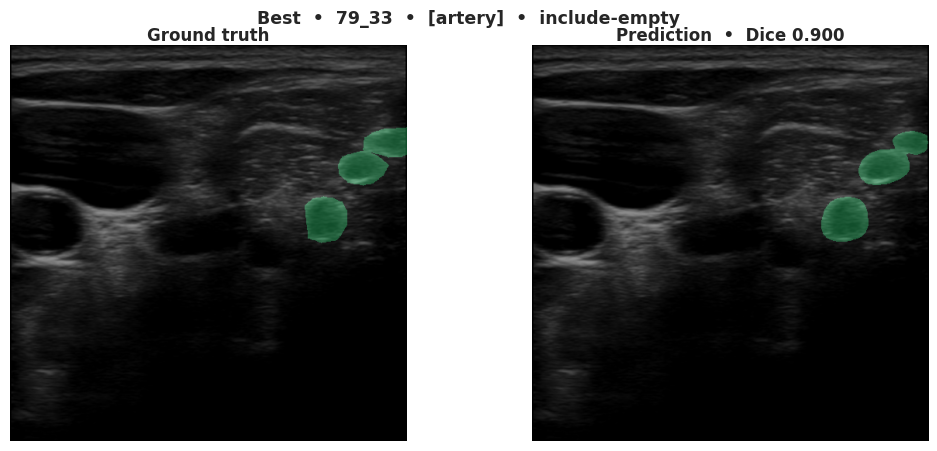

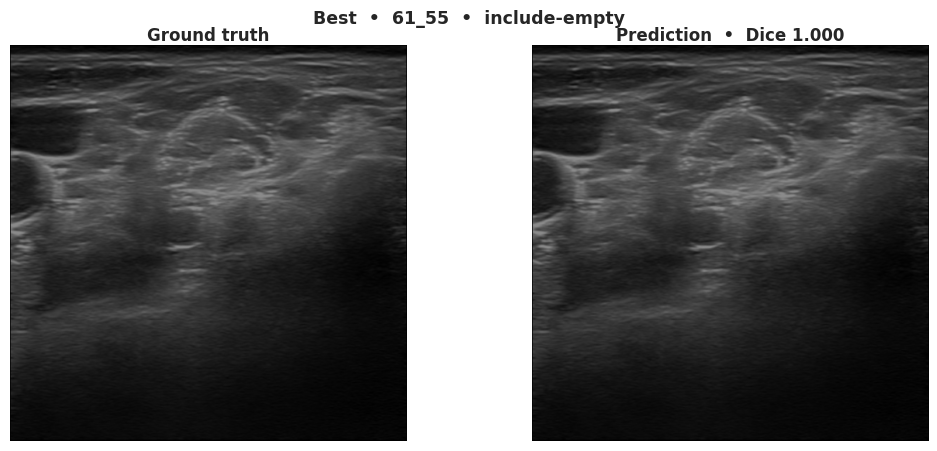


🎯 Average overall Dice across folds: 0.3930 ± 0.0442  (n=5)

📌 Per-landmark average Dice across folds:
  1: dongmai (artery)     mean±std: 0.3930 ± 0.0442  (folds=5)

✅ Experiment complete across folds.


In [12]:
import torch

variants = {
    "model": "unet",
    "cv": 5,
    "include_classes": [4],

    "epochs": 100,
    "batch_size": 16,
    "num_workers": 2,
    "image_size": 512,
    
    "patience": 20,
    "scheduler": "plateau",
    "plateau_cooldown": 10,
    
    "half_precision": True,
    "ignore_empty": False,
    "augment": True,
    "cuda": "cuda" if torch.cuda.is_available() else "cpu",
    "use_wandb": False,
    "save_dir": "../../checkpoints"
}

res = experiment(variants, 42)